# Hopfield Networks 3

Investigate the "energy model" underlying Hopfield networks and demonstrate how symmetric weight matrices ensure convergence.

In [1]:
import sys
sys.path.append('..')

import matplotlib.pyplot as plt
import numpy as np
np.random.seed(9)

from lib.hopfield_network import *
from lib.plotting import figsize, subplots

# Train Network

In [2]:
model = HopfieldNetwork()
model.train(TRAINING_PATTERNS);


In [3]:
pict = np.genfromtxt('../data/pict.dat', delimiter=',', dtype=np.int8).reshape(11, 1024)

model_pict = HopfieldNetwork()
model_pict.train(pict[:3, :]);

# Attractor Energies

In [4]:
for attractor in model.attractors():
    print("{} => {}".format(attractor, model.energy(attractor)))

[-1 -1  1 -1  1  1 -1  1] => -7.0
[ 1  1  1  1 -1  1  1  1] => -4.5
[ 1  1 -1  1 -1  1  1 -1] => -8.5
[-1  1 -1 -1 -1  1 -1 -1] => -7.0
[-1 -1 -1 -1 -1  1 -1 -1] => -8.5
[ 1  1 -1  1  1  1  1 -1] => -7.0
[-1  1  1 -1  1 -1 -1  1] => -7.0
[-1 -1  1 -1 -1  1 -1  1] => -8.5
[ 1  1  1  1  1 -1  1  1] => -8.5
[-1 -1  1 -1  1 -1 -1  1] => -8.5
[ 1  1 -1  1  1 -1  1 -1] => -8.5
[ 1 -1 -1  1  1 -1  1 -1] => -9.0
[-1 -1 -1 -1  1 -1 -1 -1] => -4.5
[-1  1  1 -1 -1  1 -1  1] => -9.0


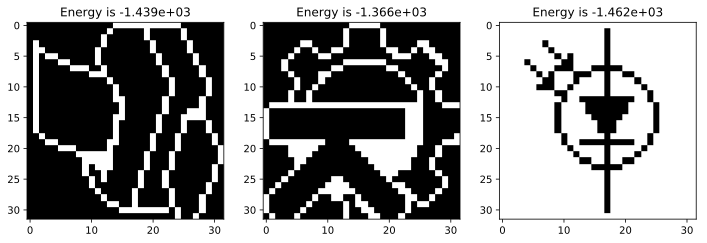

In [5]:
_, axes = subplots(1, 3)

for j, attractor in enumerate([pict[i, :] for i in range(3)]):
    axes[j].imshow(attractor.reshape(32, 32), cmap='gray')
    axes[j].set_title("Energy is {:1.3e}".format(model_pict.energy(attractor)))
    
plt.savefig('../figures/attractor_energies.svg')

# Distorted Pattern Energies

In [6]:
for pattern in DISTORTED_PATTERNS:
    print("{} => {}".format(pattern, model.energy(pattern)))

[ 1 -1  1 -1  1 -1 -1  1] => -5.0
[ 1  1 -1 -1 -1  1 -1 -1] => -4.5
[ 1  1  1 -1 -1  1 -1  1] => -4.5


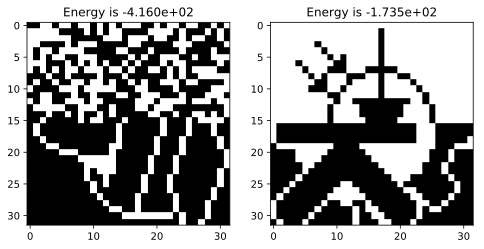

In [7]:
_, axes = subplots(1, 2)

for j, attractor in enumerate([pict[i, :] for i in [9, 10]]):
    axes[j].imshow(attractor.reshape(32, 32), cmap='gray')
    axes[j].set_title("Energy is {:1.3e}".format(model_pict.energy(attractor)))
    
plt.savefig('../figures/distorted_energies.svg')

# Follow Energy Changes

In [31]:
def plot_recall_energy_curve(model, pattern_init, runs=1, ax=None):
    if ax is None:
        _, ax = subplots(1, 1, size=figsize(2, 2))

    i_max = 0
    for r in range(runs):
        pattern = pattern_init
        last_pattern = pattern_init

        energies = [model.energy(pattern_init)]

        i = 1
        while True:
            sys.stdout.write("{} ({}/{})".format(i, r + 1, runs).ljust(80) + "\r")
            sys.stdout.flush()

            pattern = model.update(pattern, synchronous=False)
            energies.append(model.energy(pattern))

            if i % pattern.shape[0] == 0:
                if np.array_equal(pattern, last_pattern):
                    energies = energies[:(-pattern.shape[0])]
                    break

                last_pattern = pattern

            i += 1

        ax.plot(energies, alpha=0.7, linewidth=2)
        
        i_max = max(i_max, i)
    
    for i in range(0, i_max, pattern.shape[0]):
        ax.axvline(i, color='r', linestyle='--')

    ax.set_title("{} => {}".format(pattern_init, pattern))
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Energy")
    
    ax.grid()

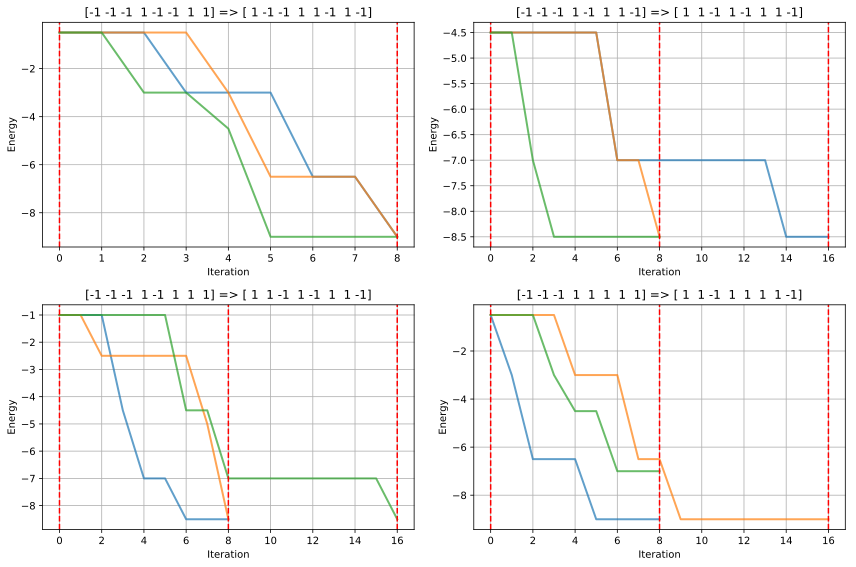

In [32]:
i_max = 0
for pattern in binary_patterns(8):
    _, i = model.recall(pattern, return_iterations=True)
    if i > i_max:
        i_max = i

patterns = []
for pattern in binary_patterns(8):
    _, i = model.recall(pattern, return_iterations=True)
    if i == i_max:
        patterns.append(pattern)

patterns = patterns[:4]

_, axes = subplots(2, 2, size=figsize(2, 3))

for pattern, ax in zip(patterns, axes.flatten()):
    plot_recall_energy_curve(model, pattern, runs=3, ax=ax)
    
plt.tight_layout()

plt.savefig('../figures/energy_curves.svg')

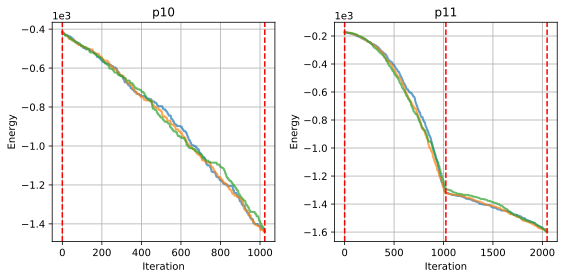

In [17]:
_, axes = subplots(1, 2)

for pattern, ax in zip([pict[i, :] for i in [9, 10]], axes):
    plot_recall_energy_curve(model_pict, pattern, runs=3, ax=ax)

axes[0].set_title("p10")
axes[1].set_title("p11")

for ax in axes:
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
    
plt.tight_layout()

plt.savefig('../figures/energy_curves_pict.svg')

# Test Convergence Behaviour for Random Weight Matrix

In [33]:
def test_convergence(model, pattern_init, iterations=None):
    pattern = pattern_init
    last_pattern = pattern_init
    all_patterns = [pattern_init]

    energies = [model.energy(pattern_init)]

    i = 1
    while True:
        sys.stdout.write("{}".format(i).ljust(80) + "\r")
        sys.stdout.flush()

        pattern = model.update(pattern, synchronous=False)
        energies.append(model.energy(pattern))
                
        if iterations is not None:
            if i == iterations:
                break
        elif i % pattern.shape[0] == 0:
            if np.array_equal(pattern, last_pattern):
                print("Recall converged after {} iterations".format(i))
                
                return energies, 0

            cycle = False
            for j, prev_pattern in enumerate(all_patterns):
                if np.array_equal(pattern, prev_pattern):
                    cycle_len = i - j + 1

                    fmt = "Recall encountered cycle of length {}"
                    print(fmt.format(cycle_len, pattern))

                    return energies, cycle_len

            last_pattern = pattern
            all_patterns.append(pattern)

        i += 1

    return energies, 0


def plot_convergence_cycles(model,
                            num_patterns=3,
                            iterations=None,
                            show_cycles=True,
                            axes=None):

    if axes is None:
        _, axes = subplots(num_patterns, 1, size=figsize(num_patterns, 2))

    if num_patterns == 1:
        axes = [axes]

    cmap = plt.get_cmap('tab10')

    patterns = [
        np.random.choice([-1, 1], size=model.weights.shape[0])
        for _ in range(num_patterns)
    ]

    if show_cycles:
        cycles = []
        for p in patterns:
            energies, cycle_len = test_convergence(model, p)
            cycles.append((len(energies) - cycle_len, len(energies) - 1))

        longest = np.argmax([c[1] for c in cycles])
        end = 2 * cycles[longest][1] - cycles[longest][0]

        if iterations is None:
            iterations = end
    else:
        cycles = [0] * len(patterns)

    for i, (p, c) in enumerate(zip(patterns, cycles)):
        energies, _ = test_convergence(
            model, p, iterations=iterations)

        axes[i].plot(energies, color=cmap(i))

        if show_cycles:
            for j in range(c[0], end + 1, c[1] - c[0]):
                axes[i].axvline(j, color=cmap(i), linestyle='--')
                
        axes[i].set_title("{}".format(p))

    for ax in axes:
        ax.set_xlabel("Iteration")
        ax.set_ylabel("Energy")

        ax.grid()

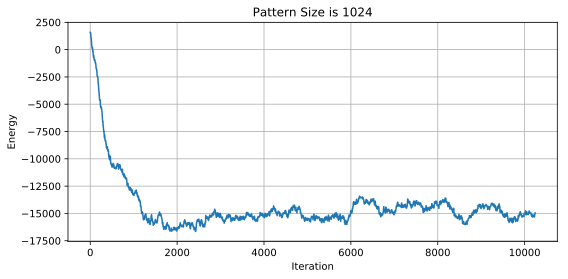

In [35]:
model_pict.weights = np.random.randn(1024, 1024)

_, ax = subplots(1, 1, size=figsize(1, 2))

plot_convergence_cycles(model_pict,
                        num_patterns=1,
                        iterations=10 * 1024,
                        show_cycles=False,
                        axes=ax)

ax.set_title("Pattern Size is 1024")

plt.tight_layout()

plt.savefig('../figures/random_weight_energy_curves.svg')

# Test Convergence Behaviour for Symmetric Weight Matrix

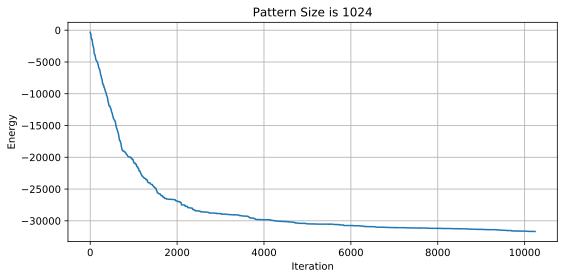

In [36]:
model_pict.weights = np.random.randn(1024, 1024)
model_pict.weights = 0.5 * (model_pict.weights + model_pict.weights.T)

_, ax = subplots(1, 1, size=figsize(1, 2))

plot_convergence_cycles(model_pict,
                        num_patterns=1,
                        iterations=10 * 1024,
                        show_cycles=False,
                        axes=ax)

ax.set_title("Pattern Size is 1024")

plt.tight_layout()

plt.savefig('../figures/random_weight_symmetric_energy_curves.svg')